## 1. import data

In [9]:
import pandas as pd

gold_standard=pd.read_csv("wri/policy-toolkit-master/data/processed/gold_standard.csv")

gold_standard.head()

,label,sentences,class
0,0,the purpose of the middle level institutions i...,1.0
1,1,"to address these challenges, the government wi...",1.0
2,2,lack of a database and information to support ...,3.0
3,3,to contribute to efforts to reduce poverty and...,3.0
4,4,secretariat. its terms of reference will inclu...,1.0


In [2]:
noisy=pd.read_csv("wri/policy-toolkit-master/data/processed/noisy.csv")
noisy.head()

,Unnamed: 0,Unnamed: 0.1,sentences,name,country,page,languages
0,0,3,part ii farm and 6. maintenance of 1 0 per c...,../data/raw/kenya/results/Agriculture Rules/1.txt,Kenya,1,en
1,1,4,1 0. harvesting. 1 1. farm forestry compensati...,../data/raw/kenya/results/Agriculture Rules/1.txt,Kenya,1,en
2,2,21,these rules may be cited as the agriculture fa...,../data/raw/kenya/results/Agriculture Rules/2.txt,Kenya,2,en
3,3,31,these rules shall apply for the purposes of pr...,../data/raw/kenya/results/Agriculture Rules/2.txt,Kenya,2,en
4,4,16,"in these rules, unless the context otherwise r...",../data/raw/kenya/results/Agriculture Rules/2.txt,Kenya,2,en


In [3]:
df1=gold_standard['sentences'].reset_index()
df1['data']='gold'
df2=noisy['sentences'].reset_index()
df2['data']='noisy'

df=pd.concat([df1,df2],ignore_index=True)

In [4]:
df

,index,sentences,data
0,0,the purpose of the middle level institutions i...,gold
1,1,"to address these challenges, the government wi...",gold
2,2,lack of a database and information to support ...,gold
3,3,to contribute to efforts to reduce poverty and...,gold
4,4,secretariat. its terms of reference will inclu...,gold
...,...,...,...
17174,16141,power of central government to amend first sch...,noisy
17175,16142,qqb the manner of usage of funds accrued to th...,noisy
17176,16143,c the amount of payment to be made to the dist...,noisy
17177,16144,15 a. the state government may prescribe the p...,noisy


## 2. data cleaning

In [5]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
nlp = spacy.load("en_core_web_sm")

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','shall','sub', 'government','act'])

def datacleaning(text=df.sentences):
    # Convert to list
    data = text.values.tolist()
    
    data_words=[]
    data_lemmatized = []
    data_lemmatized2 = []
    allowed_postags=['NOUN', 'VERB']
    for sent in data:
        # Remove distracting single quotes
        tmp=re.sub(r"\'", "", sent)
        
        # Tokenization & Remove stopwords
        tmp=gensim.utils.simple_preprocess(str(tmp), deacc=True)
        tmp2=[]
        for item in tmp:
            if item not in stop_words:
                tmp2.append(item)
        data_words.append(tmp2)  # deacc=True removes punctuations
        
        # Lemmatization
        doc = nlp(" ".join(tmp2)) 
        token_tmp=[token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
        data_lemmatized.append(" ".join(token_tmp))
        data_lemmatized2.append(token_tmp)

    return data_lemmatized,data_lemmatized2

In [7]:
data_lemmatized, data_lemmatized2=datacleaning(df.sentences)

In [8]:
data_lemmatized[:2]

['purpose level institution provide link level implementation asd support coordination ministry stakeholder connection follow institution strengthen coordination committee icc expand include ministry provide service sector icc compose secretary collaborate ministry coordinate planning strategy sector level monitoring implementation ensure goal achieve',
 'address challenge implement development policy rationalize restructure authority consolidate development act emphasis develop resource master plan implement integrate development programme create impact region follow intervention implement implement policy reform strengthen development planning develop conserve river bank water body catchment area develop community support empowerment programme formulate implement integrate basin base development programme']

In [9]:
data_lemmatized2[:1]

[['purpose',
  'level',
  'institution',
  'provide',
  'link',
  'level',
  'implementation',
  'asd',
  'support',
  'coordination',
  'ministry',
  'stakeholder',
  'connection',
  'follow',
  'institution',
  'strengthen',
  'coordination',
  'committee',
  'icc',
  'expand',
  'include',
  'ministry',
  'provide',
  'service',
  'sector',
  'icc',
  'compose',
  'secretary',
  'collaborate',
  'ministry',
  'coordinate',
  'planning',
  'strategy',
  'sector',
  'level',
  'monitoring',
  'implementation',
  'ensure',
  'goal',
  'achieve']]

## 3.1 Topic modeling-NMF(Non-negative Matrix Factorization) with unigram

In [ ]:
# The LDA topic model algorithm requires a document word matrix as the main input.

In [10]:
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(analyzer='word',  
                                   max_df=0.85,   #ignore terms that have a document frequency strictly higher than 0.85
                                   min_df=10, 
                                   stop_words='english',
                                   lowercase=True,  # convert all words to lowercase
                                   token_pattern='[a-zA-Z0-9]{3,}' # num chars > 3
                                  )
tfidf = tfidf_vectorizer.fit_transform(data_lemmatized)


# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(analyzer='word',
                                max_df=0.85, 
                                min_df=10,  # minimum reqd occurences of a word 
                                stop_words='english',  # remove stop words
                                lowercase=True,  # convert all words to lowercase
                                token_pattern='[a-zA-Z0-9]{3,}' # num chars > 3
                               )
tf = tf_vectorizer.fit_transform(data_lemmatized)


In [37]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,  # Number of topics
                                      max_iter=10,  # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,  # Random state
                                      batch_size=128,  # n docs in each learning iter
                                      evaluate_every = -1,  # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(tfidf)

In [38]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(tfidf))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(tfidf))

Log Likelihood:  -563547.3551707042
Perplexity:  7788.937607017498


#### Use GridSearch to determine the best LDA model.

In [11]:
# Define Search Param
search_params = {'n_components': [3,5,7], 'learning_decay': [.7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(tfidf)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       iid=True, n_jobs=1,
       param_grid={'n_topics': [3, 5, 10, 20, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

C:\Programs\anaconda\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method=None,
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=1,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_

In [12]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(tfidf))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -169700.2526433849
Model Perplexity:  1939.509075177583


In [13]:
# Create Document — Topic Matrix
lda_output = best_lda_model.transform(tfidf)
# column names
topicnames = ['Topic' + str(i) for i in range(best_lda_model.n_components)]
# index names
docnames = ['Doc' + str(i) for i in range(len(df))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.06,0.14,0.8,2
Doc1,0.14,0.06,0.81,2
Doc2,0.08,0.09,0.83,2
Doc3,0.07,0.06,0.87,2
Doc4,0.06,0.1,0.84,2
Doc5,0.06,0.06,0.88,2
Doc6,0.06,0.06,0.87,2
Doc7,0.12,0.07,0.81,2
Doc8,0.11,0.06,0.82,2
Doc9,0.11,0.1,0.79,2


In [14]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = tfidf_vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,abadi,abandon,abandonment,abate,abatement,abide,ability,abolish,absence,absorb,...,xiv,xvii,yard,year,yield,yojana,youth,zinc,zone,zoo
Topic0,0.568343,4.142422,0.346764,0.417023,1.468682,0.360869,6.251802,0.351889,2.648573,1.305857,...,0.341288,0.358653,5.626041,46.918924,24.215733,0.358128,0.346075,4.985859,30.918383,2.821845
Topic1,8.531838,5.960232,12.916384,2.358469,0.357823,3.293798,0.392136,4.253874,12.506729,0.335549,...,3.728933,3.822864,0.349434,119.772677,0.336614,0.500321,0.337795,0.359839,0.347380,8.180664
Topic2,0.336823,0.374105,0.340873,0.842518,2.707086,0.406157,6.633626,0.341131,4.299356,0.680979,...,0.389062,0.339678,0.334869,36.292863,0.363665,3.904646,30.139135,0.337653,10.626953,0.384106


In [15]:
# Show top n keywords for each topic
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=tfidf_vectorizer, lda_model=best_lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,area,water,forest,land,tree,specie,irrigation,plant,crop,elephant,rate,produce,use,soil,habitat
Topic 1,section,state,person,land,rule,officer,make,order,authority,member,date,lease,mining,mineral,committee
Topic 2,development,management,policy,resource,forest,plan,sector,level,develop,community,project,programme,activity,need,support


In [16]:
print(len(df))
print(len(df_document_topic['dominant_topic']))

17179
17179


In [17]:
df['topic_unigram']= list(df_document_topic['dominant_topic'])

In [18]:
df

,index,sentences,data,topic_unigram
0,0,the purpose of the middle level institutions i...,gold,2
1,1,"to address these challenges, the government wi...",gold,2
2,2,lack of a database and information to support ...,gold,2
3,3,to contribute to efforts to reduce poverty and...,gold,2
4,4,secretariat. its terms of reference will inclu...,gold,2
...,...,...,...,...
17174,16141,power of central government to amend first sch...,noisy,1
17175,16142,qqb the manner of usage of funds accrued to th...,noisy,1
17176,16143,c the amount of payment to be made to the dist...,noisy,1
17177,16144,15 a. the state government may prescribe the p...,noisy,1


In [19]:
df.groupby('topic_unigram').size()

topic_unigram
0    3701
1    6793
2    6685
dtype: int64

In [81]:
df[df['data']=='gold'].groupby('topic_unigram').size()

topic_unigram
0    217
1    160
2    656
dtype: int64

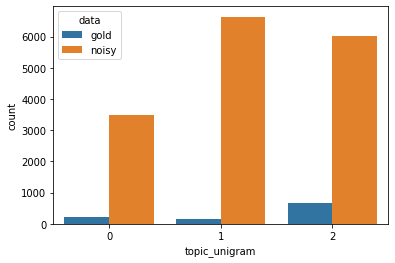

In [82]:
import seaborn as sns
ax = sns.countplot(x="topic_unigram", hue="data", data=df)

## 3.2 Topic modeling-genism LDA with bigram

In [20]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

nlp = spacy.load("en_core_web_sm")

In [21]:
from nltk import word_tokenize, sent_tokenize, ngrams, pos_tag, RegexpParser
from collections import Counter

In [22]:
bitokens=[[] for i in range(len(data_lemmatized2))]
for idx in range(len(data_lemmatized2)):
    for token in ngrams(data_lemmatized2[idx],2):
        bitokens[idx].append(token[0]+'_'+token[1])

In [23]:
bitokens[12]

['thrust_increase',
 'increase_productivity',
 'productivity_competitiveness',
 'competitiveness_commodity',
 'commodity_enable',
 'enable_sector',
 'sector_export',
 'export_output',
 'output_earn',
 'earn_country',
 'country_exchange',
 'exchange_create',
 'create_employment',
 'employment_sector',
 'sector_spread',
 'spread_ministry',
 'ministry_need',
 'need_partnership',
 'partnership_ministry',
 'ministry_stakeholder',
 'stakeholder_implementation',
 'implementation_asd',
 'asd_require',
 'require_partnership',
 'partnership_sector',
 'sector_development',
 'development_partner',
 'partner_non',
 'non_state',
 'state_actor',
 'actor_sector',
 'sector_approach',
 'approach_coordination',
 'coordination_mechanism',
 'mechanism_success',
 'success_strategy']

In [24]:
# Create Dictionary
id2word = corpora.Dictionary(bitokens)

# Create Corpus
import copy 
texts = copy.deepcopy(bitokens)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in bitokens]

# View
print(corpus[:1])

# The produced corpus shown above is a mapping of (word_id, word_frequency).

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1)]]


In [119]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('asd_support', 1),
  ('collaborate_ministry', 1),
  ('committee_icc', 1),
  ('compose_secretary', 1),
  ('connection_follow', 1),
  ('coordinate_planning', 1),
  ('coordination_committee', 1),
  ('coordination_ministry', 1),
  ('ensure_goal', 1),
  ('expand_include', 1),
  ('follow_institution', 1),
  ('goal_achieve', 1),
  ('icc_compose', 1),
  ('icc_expand', 1),
  ('implementation_asd', 1),
  ('implementation_ensure', 1),
  ('include_ministry', 1),
  ('institution_provide', 1),
  ('institution_strengthen', 1),
  ('level_implementation', 1),
  ('level_institution', 1),
  ('level_monitoring', 1),
  ('link_level', 1),
  ('ministry_coordinate', 1),
  ('ministry_provide', 1),
  ('ministry_stakeholder', 1),
  ('monitoring_implementation', 1),
  ('planning_strategy', 1),
  ('provide_link', 1),
  ('provide_service', 1),
  ('purpose_level', 1),
  ('secretary_collaborate', 1),
  ('sector_icc', 1),
  ('sector_level', 1),
  ('service_sector', 1),
  ('stakeholder_connection', 1),
  ('strategy_

In [25]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [292]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=bitokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.468754950610345

Coherence Score:  0.5344949438445165


In [ ]:
# I cannot get the data visualization result when I run this cell locally.
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [294]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bitokens, start=2, limit=10, step=1,id2word=id2word)

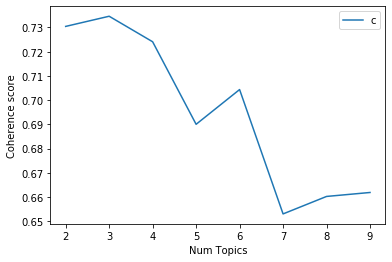

In [296]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Select the model and print the topics
optimal_model = model_list[1]  # num topics=14
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [26]:
model_topics = lda_model.show_topics(formatted=False)
pprint(lda_model.print_topics(num_words=15))

[(0,
  '0.003*"timing_start" + 0.002*"responsibility_moef" + 0.002*"climate_change" '
  '+ 0.002*"water_course" + 0.002*"protect_area" + 0.002*"revenue_officer" + '
  '0.002*"biodiversity_conservation" + 0.002*"land_revenue" + '
  '0.002*"forest_land" + 0.002*"wildlife_conservation" + '
  '0.001*"start_responsibility" + 0.001*"endanger_specie" + '
  '0.001*"supply_water" + 0.001*"flora_fauna" + 0.001*"wildlife_protection"'),
 (1,
  '0.006*"section_section" + 0.006*"mining_lease" + 0.003*"case_may" + '
  '0.003*"prospect_licence" + 0.002*"term_condition" + 0.002*"rule_make" + '
  '0.002*"state_may" + 0.002*"may_prescribe" + 0.002*"propagating_material" + '
  '0.002*"land_revenue" + 0.001*"anything_contain" + 0.001*"provision_section" '
  '+ 0.001*"variety_register" + 0.001*"may_extend" + 0.001*"breeder_variety"'),
 (2,
  '0.003*"state_government" + 0.002*"responsibility_moef" + '
  '0.001*"effort_make" + 0.001*"benefit_sharing" + '
  '0.001*"start_responsibility" + 0.001*"action_plan" +

In [28]:
## Finding the dominant topic in each sentence

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    
    for i in range(len(ldamodel[corpus])):
        topic_num=ldamodel[corpus][i][0][0][0]
        prop_topic=ldamodel[corpus][i][0][0][1]
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df.sentences)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Text
0,0,2.0,0.9874,the purpose of the middle level institutions i...
1,1,0.0,0.2099,"to address these challenges, the government wi..."
2,2,1.0,0.0137,lack of a database and information to support ...
3,3,0.0,0.7313,to contribute to efforts to reduce poverty and...
4,4,0.0,0.1032,secretariat. its terms of reference will inclu...
5,5,0.0,0.3272,the government shall also further reform and s...
6,6,0.0,0.9799,the government has taken bold measures to comb...
7,7,1.0,0.0124,energy is one of the infrastructural enablers ...
8,8,0.0,0.2856,the youth will be sensitized on lucrative vent...
9,9,0.0,0.0136,much of the current planning is as a result of...


In [29]:
df_dominant_topic.groupby('Dominant_Topic').size()

Dominant_Topic
0.0    13776
1.0     2923
2.0      480
dtype: int64

In [30]:
df['topic_bigram']= list(df_dominant_topic['Dominant_Topic'])

In [31]:
df.head()

,index,sentences,data,topic_unigram,topic_bigram
0,0,the purpose of the middle level institutions i...,gold,2,2.0
1,1,"to address these challenges, the government wi...",gold,2,0.0
2,2,lack of a database and information to support ...,gold,2,1.0
3,3,to contribute to efforts to reduce poverty and...,gold,2,0.0
4,4,secretariat. its terms of reference will inclu...,gold,2,0.0


In [32]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(2)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Text
0,0.0,0.9983,this case study explores the role of the fores...
1,0.0,0.9979,"b horticultural trees species like mango, guav..."
2,1.0,0.9984,xlvi the manner of giving notice under sub-sec...
3,1.0,0.9983,"of borehole cores, plans, sections, reports, r..."
4,2.0,0.9975,the county governments will play a pivotal rol...
5,2.0,0.9975,"2,649 km on periodic maintenance and 23 6,603 ..."


In [343]:
for item in sent_topics_sorteddf_mallet['Text']:
    pprint(item)
    print()

('health care subsidies for social health protection this will be achieved '
 'through the following strategiesconsolidating, expanding new and existing '
 'and coordinating social health subsidy mechanism for the poor with a view of '
 'achieving universal coverage;provision of free maternity services in all '
 'public health facilities;expanding coverage of health benefits to all the '
 'indigents;establishing a national social health insurance mechanism that '
 'caters for employees, employers and the informal sector with a view to gain '
 'universal coverage;reforming national hospital insurance fund naif to '
 'effectively act as a vehicle to implement the national health insurance '
 'scheme;designing a harmonized and progressive resource mobilization '
 'strategies targeting all sources of funds, both domestic and '
 'international;strengthening programming of external funding of health '
 'through improved harmonization and alignment to sector priorities and '
 'improved report

 'of capacity building, and coordination. the sch policy 200 9 goal is to '
 'attain sustainable economic growth that is driven by science, technology and '
 'innovation and its objective is to provide guidance and support for the '
 'development and application of sti. the sch policy 200 9 has 1 4 priority '
 'areas and priority area 1 3 is on climate change and environment. the goal '
 'of the thematic area is to ensure sound environmental management in order to '
 'mitigate against climate change, specifically, ensuring;availability of '
 'appropriate technologies to adapt and mitigate against effects of climate '
 'change; ii capacity development in climate monitoring and early warning; iii '
 'in depth understanding and awareness of the impacts of climate change; and '
 'iv contribution to mainstreaming climate change, particularly adaptation, in '
 'national development. from the foregoing, it is clear that the science and '
 'technology sector has embraced climate change issues 

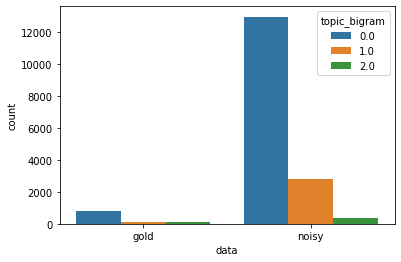

In [33]:
import seaborn as sns
ax = sns.countplot(x="data", hue="topic_bigram", data=df)

## 4. export the dataset with dominant topics(unigram and bigram)

In [2]:
import numpy as np
noisy_proba = np.load("yg2619/policy-toolkit/columbia_codes/data/snorkel_noisy_proba_updated.npy")

In [8]:
noisy_proba.argmax(1)[99]

0

In [12]:
gold_standard.head()

,label,sentences,class
0,0,the purpose of the middle level institutions i...,1.0
1,1,"to address these challenges, the government wi...",1.0
2,2,lack of a database and information to support ...,3.0
3,3,to contribute to efforts to reduce poverty and...,3.0
4,4,secretariat. its terms of reference will inclu...,1.0


In [16]:
gold_standard['class2']=''
gold_standard.loc[gold_standard['class'] == 1.0, 'class2'] = 0
gold_standard.loc[gold_standard['class'] == 2.0, 'class2'] = 0
gold_standard.loc[gold_standard['class'] == 3.0, 'class2'] = 1

In [20]:
classlist=list(gold_standard['class2'])
for item in noisy_proba.argmax(1):
    classlist.append(item)

In [22]:
print(len(classlist))
print(len(df))

17179
17179


In [23]:
df['class']=classlist

In [24]:
df.head()

,index,sentences,data,topic_unigram,topic_bigram,class
0,0,the purpose of the middle level institutions i...,gold,2,2.0,0
1,1,"to address these challenges, the government wi...",gold,2,0.0,0
2,2,lack of a database and information to support ...,gold,2,1.0,1
3,3,to contribute to efforts to reduce poverty and...,gold,2,0.0,1
4,4,secretariat. its terms of reference will inclu...,gold,2,0.0,0


In [25]:
## I tried to get the senti score by counting positive words and negative words, but the result is not good.
## Another method for sentiment analysis: TextBlob is actually a high level library built over top of NLTK library. 
## TextBlob uses a Movies Reviews dataset in which reviews have already been labelled as positive or negative.
## Training data now consists of labelled positive and negative features. This data is trained on a Naive Bayes Classifier.

# ! pip install textblob
from textblob import TextBlob 
textbloblist=[]
for sent in df.sentences:
    textbloblist.append(TextBlob(sent).sentiment.polarity)

In [26]:
textbloblist.count(0)

5305

In [27]:
len(textbloblist)

17179

In [28]:
df['sentiscore']=textbloblist

In [29]:
df.head()

,index,sentences,data,topic_unigram,topic_bigram,class,sentiscore
0,0,the purpose of the middle level institutions i...,gold,2,2.0,0,0.040000
1,1,"to address these challenges, the government wi...",gold,2,0.0,0,0.183333
2,2,lack of a database and information to support ...,gold,2,1.0,1,0.104167
3,3,to contribute to efforts to reduce poverty and...,gold,2,0.0,1,-0.041667
4,4,secretariat. its terms of reference will inclu...,gold,2,0.0,0,0.120000


In [30]:
df.to_csv("yg2619/policy-toolkit/columbia_codes/data/alldata_with_topic_sentiscore.csv",index=False)

## 5. explore the results

In [33]:
sentiment=[]
for item in df.sentiscore:
    if item > 0:
        sentiment.append('positive')
    elif item == 0:
        sentiment.append('neutral')
    else:
        sentiment.append('negative')

In [ ]:
df['sentiment']=sentiment

In [37]:
df.head()

,index,sentences,data,topic_unigram,topic_bigram,class,sentiscore,sentiment
0,0,the purpose of the middle level institutions i...,gold,2,2.0,0,0.040000,positive
1,1,"to address these challenges, the government wi...",gold,2,0.0,0,0.183333,positive
2,2,lack of a database and information to support ...,gold,2,1.0,1,0.104167,positive
3,3,to contribute to efforts to reduce poverty and...,gold,2,0.0,1,-0.041667,negative
4,4,secretariat. its terms of reference will inclu...,gold,2,0.0,0,0.120000,positive


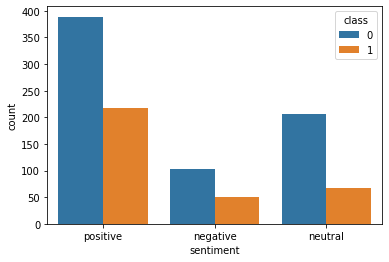

In [39]:
import seaborn as sns
ax = sns.countplot(x="sentiment", hue="class", data=df[df['data']=='gold'])
ax

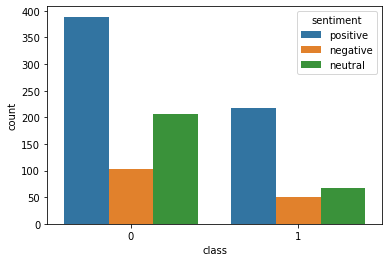

In [40]:
sns.countplot(x="class", hue="sentiment", data=df[df['data']=='gold'])

## in the 'positive' class, the number of sentences with positive sentiment is apparently larger than the number of sentences with other sentiments.

In [36]:
df.groupby(['data','class','sentiment']).size()

data   class  sentiment
gold   0      negative      103
              neutral       206
              positive      389
       1      negative       51
              neutral        67
              positive      217
noisy  0      negative     3040
              neutral      4958
              positive     7803
       1      negative       79
              neutral        74
              positive      192
dtype: int64